# Install Packages

In [23]:
#!pip install pycaret[full]
#!pip install explainerdashboard
#!pip install --upgrade fairlearn==0.7.0 raiwidgets

# Import Modules

In [24]:
import os
from pathlib import Path
from google.colab import drive
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.metrics import roc_curve, precision_recall_curve


# Set Hyperparameters

In [25]:
# set seed for reproducibility
seed = 123

# define features and target
features = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age']
target = 'Diabetic'

# Mount Google Drive and Set Paths

In [26]:
# mount data
gdrive_path = '/content/gdrive' 
drive.mount(gdrive_path)

# set paths
ROOTDIR = os.path.join(gdrive_path, 'MyDrive', 'Healthrisk_Modeling')
DATAPATH = os.path.join(ROOTDIR, 'data')

# make folders
Path(DATAPATH).mkdir(parents=True, exist_ok=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Helper Functions

In [28]:
def generate_random_indices(n:int, range_min:int, range_max:int, seed:int)->list:
  """ generate n random indices in given range for given seed. """
  random.seed(seed)
  random_indices = random.sample(range(range_min, range_max), n)
  return random_indices

def add_NAs_to_features(data:pd.DataFrame, feature_list:list, number_na:int, seed:int):
  """ Add number_na NAs in given features i.e. feature_list to given dataframe i.e. data. provide seed for reproducibility. """
  counter = 0
  for column in feature_list:
    counter += 1
    print('add NAs to feature ', column)
    # lets generate NAs in number_na rows
    random_indices = generate_random_indices(n=number_na, 
                                            range_min=0, range_max=data.shape[0], 
                                            seed=seed+counter)
    # impute NAs at random indices
    data.loc[random_indices, column] = np.nan
  return data

def visualize_numfeatures_stratifiedbytarget(data:pd.DataFrame, numeric_features:list, target:str, positive_class:str, negative_class:str):
  """ Plot histograms and boxplots for numeric features given a binary target """
  for col in numeric_features:
    try:
      fig, ax = plt.subplots(1,2, figsize=(12,5))
      
      sns.histplot(data=data, 
                  x=col, 
                  hue=target, 
                  stat='percent', 
                  kde=True,
                  element='step',
                  ax=ax[0])
      ax[0].set_title(col)
      ax[0].legend([positive_class, negative_class])

      sns.boxplot(data=data, 
                  y=col, 
                  x=target,
                  ax=ax[1])
      ax[1].set_title(col)
      ax[1].set_xticklabels([negative_class, positive_class])

      plt.show()
    except:
      print('Singular matrix error due to constant feature value')

# Data Import

In [29]:
# load the diabetes dataset
print("Loading Data...")
df = pd.read_csv(Path(DATAPATH) / 'diabetes.csv')
df.head()

Loading Data...


,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


# Exploratory Data Analysis

In [30]:
df.shape

(10000, 10)

nice, we got 10.000 rows 8 features and one target column; thats sth to work with

In [31]:
df.isnull().sum()

PatientID                 0
Pregnancies               0
PlasmaGlucose             0
DiastolicBloodPressure    0
TricepsThickness          0
SerumInsulin              0
BMI                       0
DiabetesPedigree          0
Age                       0
Diabetic                  0
dtype: int64

ups, no NAs, not quite realistic, lets produce some NAs at random

In [32]:
df = add_NAs_to_features(data=df, feature_list=features, number_na=1000, seed=seed)

add NAs to feature  Pregnancies
add NAs to feature  PlasmaGlucose
add NAs to feature  DiastolicBloodPressure
add NAs to feature  TricepsThickness
add NAs to feature  SerumInsulin
add NAs to feature  BMI
add NAs to feature  DiabetesPedigree
add NAs to feature  Age


In [33]:
df.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0.0,171.0,80.0,34.0,23.0,43.509726,1.213191,21.0,0
1,1147438,8.0,NaN,93.0,47.0,36.0,21.240576,0.158365,23.0,0
2,1640031,7.0,115.0,47.0,52.0,35.0,41.511523,0.079019,23.0,0
3,1883350,9.0,103.0,78.0,25.0,304.0,29.582192,1.282870,43.0,1
4,1424119,1.0,85.0,59.0,27.0,NaN,42.604536,0.549542,22.0,0


In [34]:
df.isnull().sum()

PatientID                    0
Pregnancies               1000
PlasmaGlucose             1000
DiastolicBloodPressure    1000
TricepsThickness          1000
SerumInsulin              1000
BMI                       1000
DiabetesPedigree          1000
Age                       1000
Diabetic                     0
dtype: int64

perfect, we got some realistic data with missing values

In [35]:
df.dtypes

PatientID                   int64
Pregnancies               float64
PlasmaGlucose             float64
DiastolicBloodPressure    float64
TricepsThickness          float64
SerumInsulin              float64
BMI                       float64
DiabetesPedigree          float64
Age                       float64
Diabetic                    int64
dtype: object

very nice, just some numeric variables, easy going

In [36]:
df.describe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1.000000e+04,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,10000.000000
mean,1.502122e+06,3.252778,107.897889,71.223333,28.839889,138.365778,31.572324,0.400529,30.116889,0.334400
std,2.892868e+05,3.407338,31.865322,16.778944,14.525064,132.916964,9.792630,0.380405,12.047213,0.471804
min,1.000038e+06,0.000000,44.000000,24.000000,7.000000,14.000000,18.200807,0.078044,21.000000,0.000000
25%,1.251672e+06,0.000000,84.000000,58.000000,15.000000,39.000000,21.250158,0.136840,22.000000,0.000000
50%,1.504394e+06,2.000000,105.000000,72.000000,31.000000,84.000000,31.946458,0.199961,24.000000,0.000000
75%,1.754608e+06,6.000000,129.000000,85.000000,42.000000,196.000000,39.340820,0.620747,35.000000,1.000000
max,1.999997e+06,14.000000,192.000000,117.000000,92.000000,796.000000,56.034628,2.301594,77.000000,1.000000


lets visualize the features to get a glance about their distribution and potential outliers

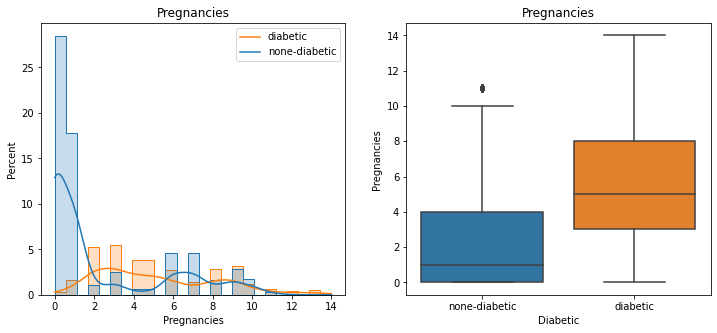

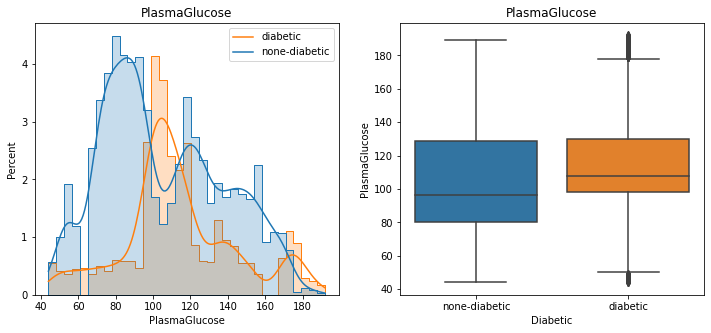

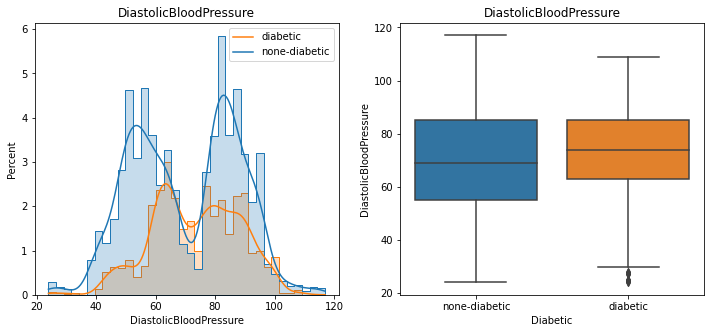

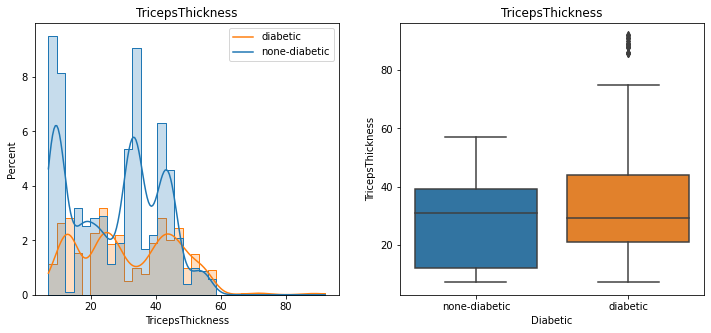

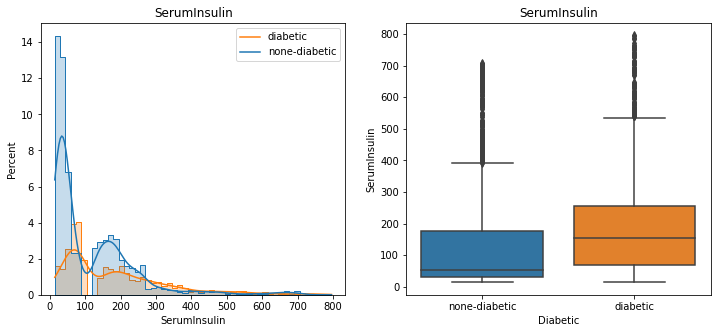

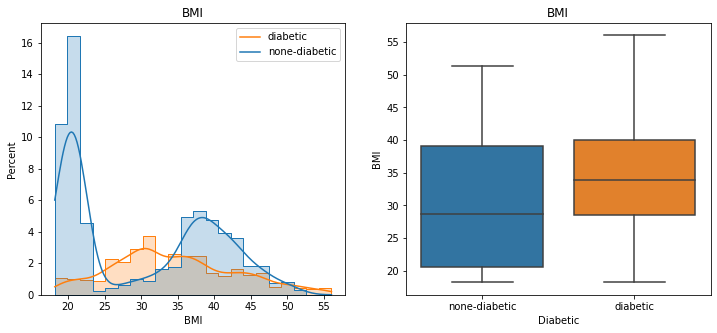

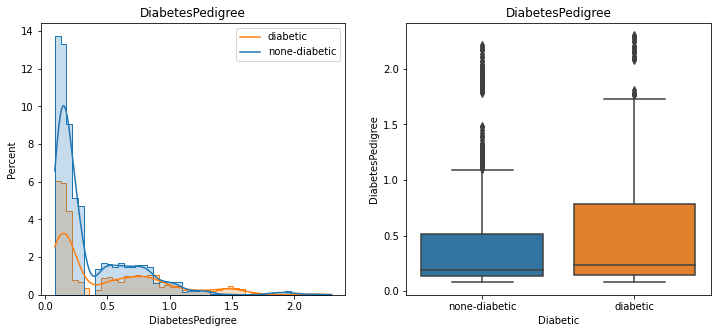

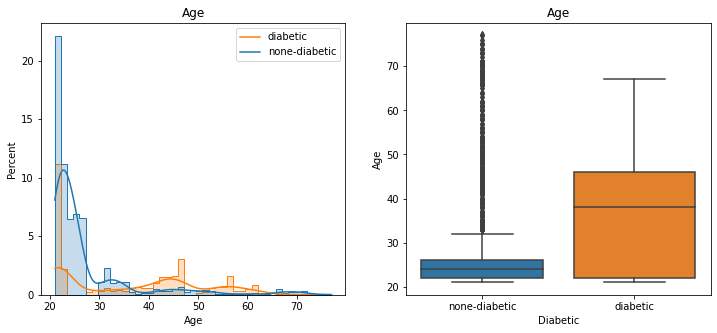

In [37]:
# plot distributions of numeric features
visualize_numfeatures_stratifiedbytarget(data=df,
                                         numeric_features=features,
                                         target=target,
                                         positive_class='diabetic',
                                         negative_class='none-diabetic')

seem like we got some outliers in seruminsulin and triceps thickness

lets have a final look at the histogram of the target variable 

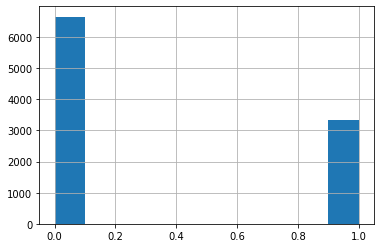

In [38]:
df[target].hist()
plt.show()

alright, got some class imbalance but not really bad

# Save the NAs data

In [39]:
df.to_csv(Path(DATAPATH) / 'diabetes_nas.csv', index=False)